# Script that parses on-road & chassis dyno data to plot NOx and CO2 emission as function of vehicle speed and compare it with COPERT5

In [9]:
VELA2Modalfiles = r'K:\PERSONNEL\Bernat\For Victor\COPERT_speed\diesel\LAB\LAB_CO2_med'    # 5 diesel veh
#Choose either PEMS or EMROAD files
# PEMSfiles = r''
EMROADfiles = r'K:\PERSONNEL\Bernat\For Victor\COPERT_speed\diesel\EMROAD\EMROAD_CO2_med'  # 5 diesel veh

In [10]:
#Select Diesel or Gasoline
fuel_type = 'Diesel' 
# fuel_type = 'Gasoline' 

In [11]:
#Select segment
segment = 'Medium' # Mini; Small; Medium; Large-SUV-Executive; N1-II

## END OF USER CHOICES

In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl

In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [14]:
if fuel_type == 'Diesel':
    UNOX = 0.001586
    UCO2 = 0.001517
elif fuel_type == 'Gasoline':
    UNOX = 0.001587
    UCO2 = 0.001518
else:
    print('Please indicate fuel_type = Diesel or Gasoline')

## 1. Parse VELA modal files

In [15]:
#Parse from each VELA2 modal file: vehicle speed and instantaneous vehicle emission (g/s)
LABS = pd.DataFrame()
os.chdir(VELA2Modalfiles)
for file in glob.glob("*.xl*"):                                                          # THIS CAN BE XLS OR XLSX, check
    print(file)
    df = pd.read_excel(file, sheetname = 'Data', header = 0, parse_cols = "A:BC")
    df = df.dropna(axis=0, how='all')
    LAB = pd.DataFrame({'Time [s]': df['DACtrl_TraceTime\n[sec]'],
                         'Vehicle speed [km/h]':df['DACtrl_ActualSpeed\n[kph]'],
                        'CO2 [g/s]': df['c_CO2_Dil_g_vec\n[grams]'],
                         'NOx [g/s]':df['c_NOx_Dil_g_vec\n[grams]']},
                        dtype=float)
    #Calculate stop periods. Stop = 1. Move = 0
    LAB.loc[LAB['Vehicle speed [km/h]'] < 1, 'STOP, 0 = YES'] = 0
    LAB.loc[LAB['Vehicle speed [km/h]'] >= 1, 'STOP, 0 = YES'] = 1
    
    #Cold emissions < 150 seconds
#     LAB.loc[LAB['Time [s]'] < 150, 'COLD, 1 = YES'] = 1
#     LAB.loc[LAB['Time [s]'] >= 150, 'COLD, 1 = YES'] = 0
    
    #Calculate distance-specific NOx emission [mg/km] and CO2 [g/km]
    #Seconds when vehicle is stopped (< 1 km/h) do not get distance-specific emission calculation.
    LAB['Inst. speed when vehicle moves'] = LAB['Vehicle speed [km/h]']*LAB['STOP, 0 = YES']
    LAB['Inst. Mass NOx when vehicle moves'] = LAB['NOx [g/s]']*LAB['STOP, 0 = YES']
    LAB['Distance when vehicle moves'] = np.where(LAB['Inst. speed when vehicle moves']>0,LAB['Inst. speed when vehicle moves']/3600,0)
    LAB['NOx [mg/km]'] = LAB['Inst. Mass NOx when vehicle moves']*1000/LAB['Distance when vehicle moves']
    LAB['Inst. Mass CO2 when vehicle moves'] = LAB['CO2 [g/s]']*LAB['STOP, 0 = YES']
    LAB['CO2 [g/km]'] = LAB['Inst. Mass CO2 when vehicle moves']/LAB['Distance when vehicle moves']
    #Reclassify vehicle speed in bins of 10 km/h. Labels indicate half of the bin speed.
    LAB['Speed range']= pd.cut(LAB['Vehicle speed [km/h]'], np.arange(0,145,10), labels=(np.arange(5,145,10)))
    LAB = LAB.dropna(axis=0, how='all')
    #Merge all routes together
    LABS = LABS.append(LAB)
LABS = LABS.reset_index()

VELA2_01072016_002_Modal_TP_NEDC_HOT_FWD_23C.xls
VELA2_01072016_004_Modal_TP_WLTP_HOT_FWD_23C.xls
VELA2_01122017_002_Modal_TP_WLTC_HOT_FWD-sync_23°C.xlsx
VELA2_01122017_006_Modal_TP_WLTC_HOT_FWD-sync_23°C.xlsx
VELA2_02052017_002_Modal_DIL_NEDC_HOT_FWD-sync_23°C.xlsx
VELA2_03052017_002_Modal_DIL_WLTP_HOT_FWD-sync_23°C.xlsx
VELA2_05042017_003_Modal_DIL_NEDC_HOT START_4WD_23°C.xls
VELA2_05052017_002_Modal_DIL_WLTP_HOT_FWD-sync_23°C.xlsx
VELA2_05072016_002_Modal_NEDC_HOT_FWD_23C.xls
VELA2_05072016_005_Modal_WLTP_HOT_FW_23C.xls
VELA2_06042017_002_Modal_DIL_NEDC_HOT START_4WD_23°C.xls
VELA2_06072016_003_Modal_WLTP_HOT_FWD_23C.xls
VELA2_06072017_003_Modal_DIL_WLTP_HOT START_4WD_23°C.xls
VELA2_06122017_002_Modal_WLTC_HOT_FWD-sync_23°C.xlsx
VELA2_07072017_002_Modal_DIL_WLTP_HOT START_4WD_23°C.xls
VELA2_11052017_002_Modal_DIL_WLTP_HOT_FWD-sync_23°C.xlsx
VELA2_13072016_003_Modal_WLTP_HOT_4WD_23C.xls
VELA2_14072016_003_Modal_NEDC_HOT_4WD_23C.xls
VELA2_15072016_005_Modal_NEDC_HOT_FWDsync_23C.xls
VE

In [139]:
LAB.columns

Index(['CO2 [g/s]', 'NOx [g/s]', 'Time [s]', 'Vehicle speed [km/h]',
       'STOP, 0 = YES', 'Inst. speed when vehicle moves',
       'Inst. Mass NOx when vehicle moves', 'Distance when vehicle moves',
       'NOx [mg/km]', 'Inst. Mass CO2 when vehicle moves', 'CO2 [g/km]',
       'Speed range'],
      dtype='object')

## 2.A Parse EMROAD files

In [16]:
#PARSE EMROAD files: vehicle speed (GPS), and instantaneous vehicle emission (g/s)
TRIPS = pd.DataFrame()
os.chdir(EMROADfiles)
for file in glob.glob("*.xlsx"):          
    veh_id = file[:5]
    route_id = file[6:9]
    test_date = datetime.strptime(file[10:20], '%Y_%m_%d')
    print('Parsing ', veh_id+'_'+route_id+' done on '+ str(test_date.strftime("%A %d. %B %Y")))
    df = pd.read_excel(file, sheetname = 'TEST DATA', skiprows = [0])
    df = df.drop(df.index[0])
    df = df.dropna(axis=0, how='all')
    TRIP = pd.DataFrame({'Time [s]': df['Time'],
                         'Vehicle speed [km/h]':df['GPS Vehicle_Speed'],
                         'NOx [ppm]':df['Wet_NOx'],
                         'CO2 [ppm]': df['Wet_CO2'],
                         'Exhaust Mass Flow [kg/h]':df['Corrected_Exhaust_Mass_Flow'],},
                        dtype=float)
    TRIP['Route'] = route_id
    TRIP['Date'] = test_date.strftime("%d/%b/%Y")
    #Calculate stop periods. Stop = 1. Move = 0
    TRIP.loc[TRIP['Vehicle speed [km/h]'] < 1, 'STOP, 0 = YES'] = 0
    TRIP.loc[TRIP['Vehicle speed [km/h]'] >= 1, 'STOP, 0 = YES'] = 1
    #Cold emissions < 150 seconds
    TRIP.loc[TRIP['Time [s]'] < 300, 'COLD, 1 = YES'] = 1
    TRIP.loc[TRIP['Time [s]'] >= 300, 'COLD, 1 = YES'] = 0
    #Calculate instaneous NOx and CO2 mass emission [g/s] from exhaust flow and wet emission
    TRIP['Inst. Mass NOx [g/s]'] = TRIP['Exhaust Mass Flow [kg/h]']*TRIP['NOx [ppm]']*UNOX/3600
    TRIP['Inst. Mass CO2 [g/s]'] = TRIP['Exhaust Mass Flow [kg/h]']*TRIP['CO2 [ppm]']*UCO2/3600
    #Calculate distance-specific NOx  [mg/km] & CO2 emission [g/km]
    #Seconds when vehicle is stopped (< 1 km/h) do not get distance-specific emission calculation.
    TRIP['Inst. speed when vehicle moves'] = TRIP['Vehicle speed [km/h]']*TRIP['STOP, 0 = YES']
    TRIP['Inst. Mass NOx when vehicle moves'] = TRIP['Inst. Mass NOx [g/s]']*TRIP['STOP, 0 = YES']
    TRIP['Distance when vehicle moves'] = np.where(TRIP['Inst. speed when vehicle moves']>0,TRIP['Inst. speed when vehicle moves']/3600,0)
    TRIP['NOx [mg/km]'] = TRIP['Inst. Mass NOx when vehicle moves']*1000/TRIP['Distance when vehicle moves']
    TRIP['Inst. Mass CO2 when vehicle moves'] = TRIP['Inst. Mass CO2 [g/s]']*TRIP['STOP, 0 = YES']
    TRIP['CO2 [g/km]'] = TRIP['Inst. Mass CO2 when vehicle moves']/TRIP['Distance when vehicle moves']
    #Reclassify vehicle speed in bins of 10 km/h. Labels indicate half of the bin speed.
    TRIP['Speed range']= pd.cut(TRIP['Vehicle speed [km/h]'], np.arange(0,145,10), labels=(np.arange(5,145,10)))
    TRIP = TRIP.dropna(axis=0, how='all')
    #Merge all routes together
    TRIPS = TRIPS.append(TRIP)
TRIPS = TRIPS.reset_index()

Parsing  CN002_ESP done on Thursday 16. June 2016
Parsing  CN002_ESP done on Friday 17. June 2016
Parsing  CN002_ESP done on Monday 20. June 2016
Parsing  CN002_ESP done on Monday 20. June 2016
Parsing  CN002_LAB done on Friday 24. June 2016
Parsing  CN002_LAB done on Friday 24. June 2016
Parsing  CN002_LAB done on Tuesday 28. June 2016
Parsing  CN002_LAB done on Tuesday 28. June 2016
Parsing  FT058_ESP done on Tuesday 18. April 2017
Parsing  FT058_ESP done on Wednesday 19. April 2017
Parsing  FT058_ESP done on Thursday 20. April 2017
Parsing  FT058_LAB done on Tuesday 18. April 2017
Parsing  FT058_LAB done on Wednesday 19. April 2017
Parsing  KA001_ESP done on Monday 20. November 2017
Parsing  KA001_ESP done on Tuesday 21. November 2017
Parsing  KA001_LAB done on Tuesday 21. November 2017
Parsing  KA001_LAB done on Friday 24. November 2017
Parsing  VW035_ESP done on Tuesday 12. July 2016
Parsing  VW035_ESP done on Tuesday 12. July 2016
Parsing  VW035_LAB done on Friday 08. July 2016
P

### 2.B alternatively parse PEMS files (AVL-MOVE)

In [ ]:
# #Parse from each PEMS file: vehicle speed (GPS), and instantaneous vehicle emission (g/s)
# TRIPS = pd.DataFrame()
# os.chdir(PEMSfiles)
# for file in glob.glob("*.xlsx"):
#     veh_id = file[:5]
#     route_id = file[6:9]
#     test_date = datetime.strptime(file[10:20], '%Y_%m_%d')
#     print('Parsing ', veh_id+'_'+route_id+' done on '+ str(test_date.strftime("%A %d. %B %Y")))
#     df = pd.read_excel(file, header = 0, parse_cols = "A:Z")
#     df = df.drop(df.index[0])
#     df = df.dropna(axis=0, how='all')
#     TRIP = pd.DataFrame({'Time [s]': df['Time'],
#                          'Vehicle speed [km/h]':df['Velocity GPS'],
#                          'NOx [ppm]':df['y_NOx'],
#                          'CO2 [ppm]': df['y_CO2'],
#                          'Exhaust Mass Flow [kg/h]':df['Exhaust Mass Flow'],},
#                         dtype=float)
#     # Calculate and append the distance array [km]
#     TRIP['Distance [km]'] = pd.Series((TRIP['Vehicle speed [km/h]']/3600), index=TRIP.index)
#     TRIP['Route'] = route_id
#     TRIP['Date'] = test_date.strftime("%d/%b/%Y")
#     #Calculate stop periods. Stop = 1. Move = 0
#     TRIP.loc[TRIP['Vehicle speed [km/h]'] < 1, 'STOP, 0 = YES'] = 0
#     TRIP.loc[TRIP['Vehicle speed [km/h]'] >= 1, 'STOP, 0 = YES'] = 1
#     #Cold emissions < 150 seconds
#     TRIP.loc[TRIP['Time [s]'] < 150, 'COLD, 1 = YES'] = 1
#     TRIP.loc[TRIP['Time [s]'] >= 150, 'COLD, 1 = YES'] = 0
#     #Calculate instaneous NOx and CO2 mass emission [g/s] from exhaust flow and wet emission
#     TRIP['Inst. Mass NOx [g/s]'] = TRIP['Exhaust Mass Flow [kg/h]']*TRIP['NOx [ppm]']*UNOX/3600
#     TRIP['Inst. Mass CO2 [g/s]'] = TRIP['Exhaust Mass Flow [kg/h]']*TRIP['CO2 [ppm]']*UCO2/3600
#     #Calculate distance-specific NOx  [mg/km] & CO2 emission [g/km]
#     #Seconds when vehicle is stopped (< 1 km/h) do not get distance-specific emission calculation.
#     TRIP['Inst. speed when vehicle moves'] = TRIP['Vehicle speed [km/h]']*TRIP['STOP, 0 = YES']
#     TRIP['Inst. Mass NOx when vehicle moves'] = TRIP['Inst. Mass NOx [g/s]']*TRIP['STOP, 0 = YES']
#     TRIP['Distance when vehicle moves'] = np.where(TRIP['Inst. speed when vehicle moves']>0,TRIP['Inst. speed when vehicle moves']/3600,0)
#     TRIP['NOx [mg/km]'] = TRIP['Inst. Mass NOx when vehicle moves']*1000/TRIP['Distance when vehicle moves']
#     TRIP['Inst. Mass CO2 when vehicle moves'] = TRIP['Inst. Mass CO2 [g/s]']*TRIP['STOP, 0 = YES']
#     TRIP['CO2 [g/km]'] = TRIP['Inst. Mass CO2 when vehicle moves']/TRIP['Distance when vehicle moves']
#     #Reclassify vehicle speed in bins of 10 km/h. Labels indicate half of the bin speed.
#     TRIP['Speed range']= pd.cut(TRIP['Vehicle speed [km/h]'], np.arange(0,145,10), labels=(np.arange(5,145,10)))
#     TRIP = TRIP.dropna(axis=0, how='all')
#     #Merge all routes together
#     TRIPS = TRIPS.append(TRIP)
# TRIPS = TRIPS.reset_index()

## 3. Split COLD and HOT emissions

In [17]:
coldTRIPS = TRIPS[TRIPS['COLD, 1 = YES'] == 1]
warmTRIPS = TRIPS[TRIPS['COLD, 1 = YES'] == 0]

In [10]:
LABS.columns

Index(['index', 'CO2 [g/s]', 'NOx [g/s]', 'Time [s]', 'Vehicle speed [km/h]',
       'STOP, 0 = YES', 'Inst. speed when vehicle moves',
       'Inst. Mass NOx when vehicle moves', 'Distance when vehicle moves',
       'NOx [mg/km]', 'Inst. Mass CO2 when vehicle moves', 'CO2 [g/km]',
       'Speed range'],
      dtype='object')

In [18]:
coldLABS = LABS#[LABS['COLD, 1 = YES'] == 1]
warmLABS = LABS#[LABS['COLD, 1 = YES'] == 0]

## 4. Import COPERT emissions
### Below is an extraction of COPERT5 emission factors for HOT and COLD emissions for EURO 6 vehicles (gasoline and diesel) for NOx and CO2. For NOx, COPERT provides a unique emission factor curve for all segments, whereas as for CO2, there are several emission factor lines depending on the vehicle segment.

In [19]:
COPERT_x = np.arange(10,140,10)
#DIESEL
## HOT NOx (Euro 6 up to 2016)
COPERT_NOxH_D_y = [818.6735244, 650.786133, 554.9328628, 488.6350055, 442.1591933, 411.9028883, 396.5422131, 396.122562, 411.9104063, 446.6303416, 505.1164426, 595.6781016, 732.9936337]
## HOT NOx LCV (Euro 6 up to 2017)
COPERT_NOxH_DLCV_y = [1315.446535, 1056.071174, 966.3911952, 922.7661543, 903.3628061, 905.4140312, 934.90859, 1006.133543, 1143.457552, 1379.609277, 1736.439437, 2173.013645, 2549.627755]
## HOT CO2 
COPERT_CO2H_D_mini_y = [205.9614428,127.8919211,105.6643416,98.50874733,97.42615155,99.29628668,102.7573462,107.1245326,112.0189459,117.2162149,122.5767304,128.0104079,133.4575731]
COPERT_CO2H_D_small_y = [268.7569869,201.7833634,171.4808445,155.0346646,145.4955563,140.0967925,137.6006418,137.4814386,139.6484265,144.3944831,152.5179486,165.7278212,187.7985386]
COPERT_CO2H_D_medium_y = [268.7569869,201.7833634,171.4808445,155.0346646,145.4955563,140.0967925,137.6006418,137.4814386,139.6484265,144.3944831,152.5179486,165.7278212,187.7985386]
COPERT_CO2H_D_LSE_y = [371.8114893,278.6017742,232.3134944,206.9172051,192.9687978,186.2899384,184.8275364,187.5466378,193.9807461,204.039236,217.9356567,236.1893114,259.691025]
COPERT_CO2H_DLCV_y = [398.8751795,281.0620062,235.9180384,214.5017732,204.2906457,200.6739172,201.6673049,206.4120283,214.6529791,226.5543252,242.6717533,264.0389623,292.3964226]


#GASOLINE
## HOT NOx
COPERT_NOxH_G_y = [55.02533777, 45.05171208, 37.90261269, 32.34940427, 27.85327257, 24.11821713, 20.9576872, 18.24469747, 15.88849121, 13.82194437, 11.99410598, 10.3654906, 8.904967399]
## HOT CO2 
COPERT_CO2H_G_mini_y = [238.0998286, 175.1471197, 140.4435812, 122.7711525, 115.5049756, 114.6495056, 117.7453852, 123.2512805, 130.1867257, 137.9209987, 146.0454992, 154.2949665, 162.4978992]
COPERT_CO2H_G_small_y = [303.6656843, 227.7744872, 183.4655019, 158.5240858, 145.6443469, 140.3683673, 139.9199999, 142.5374995, 147.0843214, 152.8172187, 159.2450414, 166.0409634, 172.9868566]
COPERT_CO2H_G_medium_y = [340.3732375, 257.5594346, 215.4681181, 191.7257645, 178.0045659, 170.5270757, 167.3630174, 167.4555069, 170.2122382, 175.3153071, 182.6273176, 192.1450204, 203.979569]
COPERT_CO2H_G_LSE_y = [533.1188866, 390.7685786, 316.8977024, 272.9201059, 244.905522, 226.6721595, 215.1429351, 208.7216504, 206.6440483, 208.7184744, 215.2707733, 227.2597736, 246.6438299]

## 5. Check speed distribution for cold and warm sections

In [20]:
a1=coldTRIPS[['NOx [mg/km]','Speed range']]
a1= a1.dropna(axis=0, how='any')
# a2 = coldLABS[['NOx [mg/km]','Speed range']]
# a2= a2.dropna(axis=0, how='any')
a3=warmTRIPS[['NOx [mg/km]','Speed range']]
a3= a3.dropna(axis=0, how='any')
a4 = warmLABS[['NOx [mg/km]','Speed range']]
a4= a4.dropna(axis=0, how='any')
c1=coldTRIPS[['CO2 [g/km]','Speed range']]
c1= c1.dropna(axis=0, how='any')
# c2 = coldLABS[['CO2 [g/km]','Speed range']]
# c2= c2.dropna(axis=0, how='any')
c3=warmTRIPS[['CO2 [g/km]','Speed range']]
c3= c3.dropna(axis=0, how='any')
c4 = warmLABS[['CO2 [g/km]','Speed range']]
c4= c4.dropna(axis=0, how='any')

In [13]:
# x = a1['Speed range'],a2['Speed range']
# fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
# colors = ['red', 'lime']
# labels = ['on-road', 'chassis dyno']
# ax0.hist(x, 13, normed=1, histtype='bar', color=colors, label=labels)
# ax0.legend(prop={'size': 14})
# ax0.set_title('Speed distribution. Bins of 10 km/h - COLD DATA', fontsize = 16)
# ax0.set_ylabel('relative time share', fontsize = 18)
# ax0.set_xlabel('vehicle speed', fontsize = 18)
# ax0.set_xticks(np.arange(10,65,10))
# plt.show()

NameError: name 'a2' is not defined

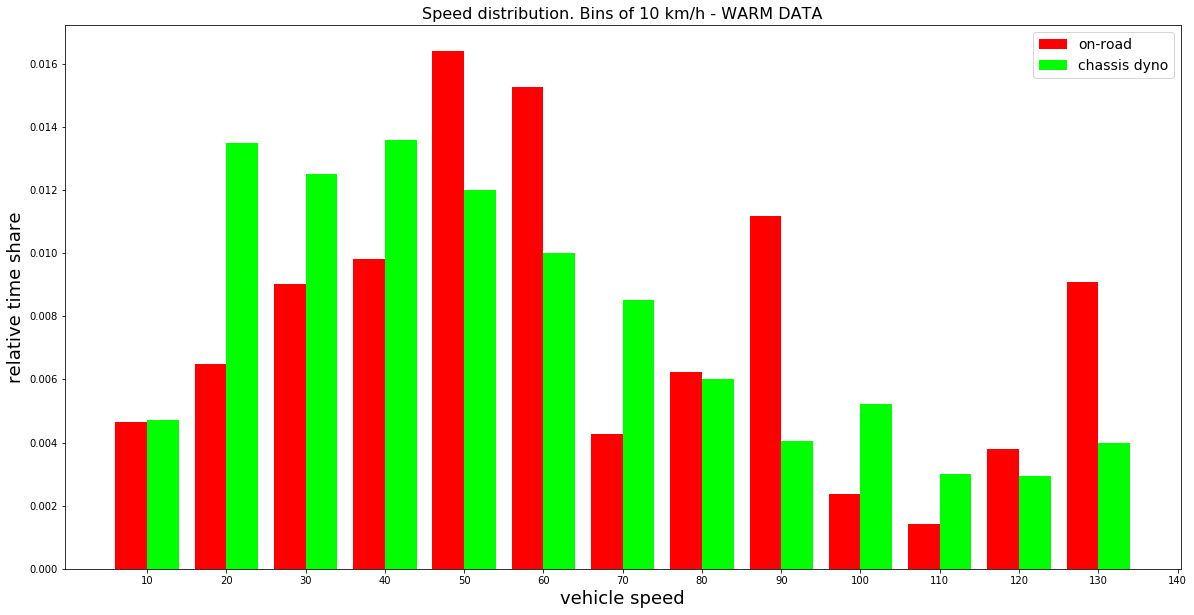

In [14]:
x = a3['Speed range'],a4['Speed range']
fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
colors = ['red', 'lime']
labels = ['on-road', 'chassis dyno']
ax0.hist(x, 13, normed=1, histtype='bar', color=colors, label=labels)
ax0.legend(prop={'size': 14})
ax0.set_title('Speed distribution. Bins of 10 km/h - WARM DATA', fontsize = 16)
ax0.set_ylabel('relative time share', fontsize = 18)
ax0.set_xlabel('vehicle speed', fontsize = 18)
ax0.set_xticks(np.arange(10,145,10))
plt.show()

# 6. Plot speed-dependent emission factors 

## CO2 WARM

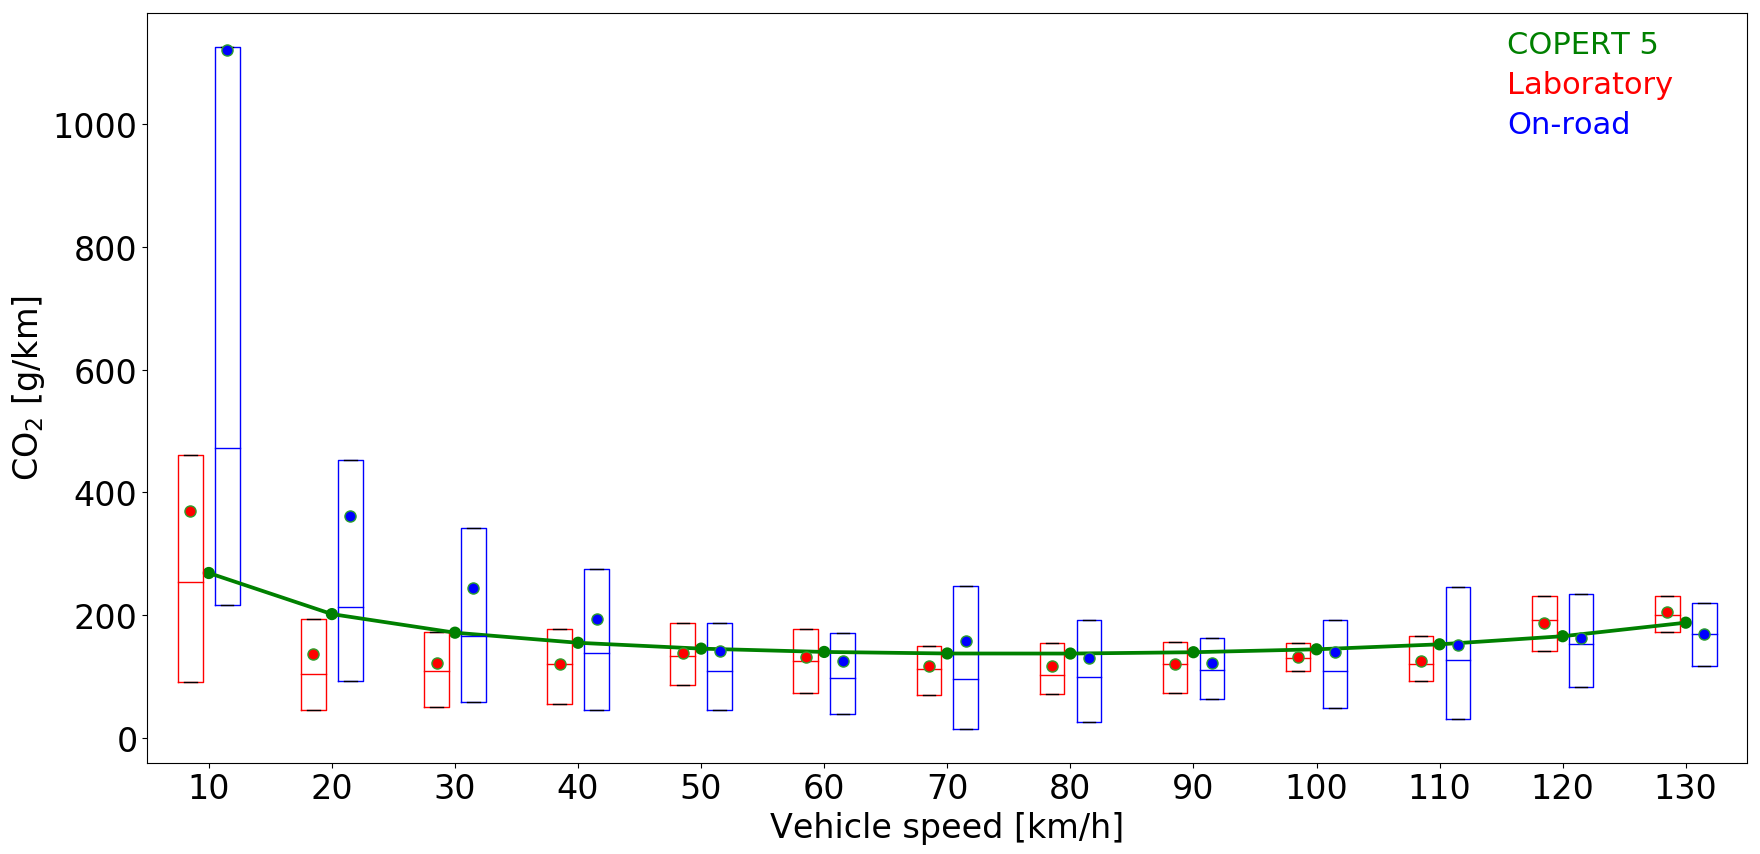

In [22]:
fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
fonstsize = 24

#c4 is warm lab
bp = c4.boxplot(by='Speed range', return_type='dict',
                                showmeans = True, grid = False, widths = 0.2, 
               positions = np.arange(14)-0.15, showfliers = False, whis = [25,75], showcaps = True, #whis = [25,75], 
               meanprops=(dict(marker='o',markerfacecolor='red', markersize=8)),
               ax=ax0)
[ [item.set_color('r') for item in bp[key]['boxes']] for key in bp.keys() ]
[ [item.set_color('r') for item in bp[key]['medians']] for key in bp.keys() ]
#c3 is warm on-road
bp2 = c3.boxplot(by='Speed range', return_type='dict',
                                showmeans = True, grid = False, widths = 0.2, 
               positions = np.arange(14)+0.15, showfliers = False, whis = [25,75], showcaps = True,
               meanprops=(dict(marker='o',markerfacecolor='blue', markersize=8)),
                ax=ax0)
[ [item.set_color('blue') for item in bp2[key]['boxes']] for key in bp2.keys() ]
[ [item.set_color('blue') for item in bp2[key]['medians']] for key in bp2.keys() ]
plt.ylabel('CO$_2$ [g/km]', fontsize = fonstsize)
plt.xlabel('Vehicle speed [km/h]', fontsize = fonstsize)
plt.xticks(fontsize = fonstsize)
plt.yticks(fontsize = fonstsize)
#plt.ylim(-10,500)
plt.suptitle("")#('COPERT 5 vs On-road vs Chassis dyno CO$_2$ emissions as function of speed', fontsize = fonstsize)
#plt.grid(True)
import seaborn as sns
if segment == 'N1-II':
    sns.pointplot(x= COPERT_x, y= COPERT_CO2H_DLCV_y, color ='green')
    plt.title(' Euro 6 light commercial vehicle - HOT emissions', fontsize = fonstsize)
elif fuel_type == 'Gasoline':
    if segment == 'Mini':
            sns.pointplot(x= COPERT_x, y= COPERT_CO2H_G_mini_y,
                         color ='green')
            plt.title('Euro 6 gasoline mini vehicle - HOT emissions', fontsize = fonstsize)
    elif segment == 'Small':
            sns.pointplot(x= COPERT_x, y= COPERT_CO2H_G_small_y,
                          color ='green')
            plt.title('Euro 6 gasoline small vehicle - HOT emissions', fontsize = fonstsize)
    elif segment == 'Medium':
            sns.pointplot(x= COPERT_x, y= COPERT_CO2H_G_medium_y,
                          color ='green')
            plt.title('Euro 6 gasoline medium vehicle - HOT emissions', fontsize = fonstsize)
    else:
        sns.pointplot(x= COPERT_x, y= COPERT_CO2H_G_LSE_y, label = 'COPERT 5', color ='green')
        plt.title('Euro 6 gasoline Large/SUV/Executive vehicle - HOT emissions', fontsize = fonstsize)
elif fuel_type == 'Diesel':
    if segment == 'Mini':
            sns.pointplot(x= COPERT_x, y= COPERT_CO2H_D_mini_y,
                          color ='green')
            plt.title('Euro 6 diesel mini vehicle - HOT emissions', fontsize = fonstsize)
    elif segment == 'Small':
            sns.pointplot(x= COPERT_x, y= COPERT_CO2H_D_small_y,
                          color ='green')
            plt.title('Euro 6 diesel small vehicle - HOT emissions', fontsize = fonstsize)
    elif segment == 'Medium':
            sns.pointplot(x= COPERT_x, y= COPERT_CO2H_D_medium_y,
                          color ='green')
            plt.title("")#('Euro 6 diesel medium vehicle - HOT emissions', fontsize = fonstsize)
    else:
        sns.pointplot(x= COPERT_x, y= COPERT_CO2H_D_LSE_y, color ='green')
        plt.title('Diesel Euro 6 diesel Large/SUV/Executive vehicle - HOT emissions', fontsize = fonstsize)
plt.figtext(0.78, 0.86, 'COPERT 5', fontsize = 22, color = 'green')
plt.figtext(0.78, 0.82, 'Laboratory', fontsize = 22, color = 'red')
plt.figtext(0.78, 0.78, 'On-road', fontsize = 22, color = 'blue')
plt.show()
mpl.rcdefaults()


### CO2 COLD

In [ ]:
# fig, ax1 = plt.subplots(figsize=(20, 10))
# #c2 is cold lab
# bp3 = c2.boxplot(by='Speed range', return_type='dict',
#                 showmeans = True, grid = False, widths = 0.2, 
#                 showfliers = False, whis = [25,75], showcaps = False,
# #                  positions = np.arange(5)-0.15,
#                 meanprops=(dict(marker='o',markerfacecolor='red', markersize=8)),
#                 ax=ax1)
# [ [item.set_color('r') for item in bp3[key]['boxes']] for key in bp3.keys() ]
# [ [item.set_color('r') for item in bp3[key]['medians']] for key in bp3.keys() ]
# #c1 is cold on-road
# bp4 = c1.boxplot(by='Speed range', return_type='dict',
#                                 showmeans = True, grid = False, widths = 0.2,
# #                  positions = np.arange(13)+0.15,
#                  showfliers = False, whis = [25,75], showcaps = False,
#                meanprops=(dict(marker='o',markerfacecolor='blue', markersize=8)),
#                 ax=ax1)
# [ [item.set_color('blue') for item in bp4[key]['boxes']] for key in bp4.keys() ]
# [ [item.set_color('blue') for item in bp4[key]['medians']] for key in bp4.keys() ]
# plt.ylabel('CO2 [g/km]', fontsize = 20)
# plt.xlabel('Vehicle speed [km/h]', fontsize = 20)
# plt.xticks(fontsize = 18)
# plt.yticks(fontsize = 18)
# plt.ylim(-10,1000)
# plt.xlim(0.5,6.5)
# plt.suptitle('On-road vs Chassis dyno CO2 distance-specific emissions as function of speed', fontsize = 20)
# if fuel_type == 'Gasoline':
#     plt.title('Diesel Euro 6 gasoline vehicle - COLD emissions', fontsize = 20)
# elif fuel_type == 'Diesel':
#     plt.title('Diesel Euro 6 diesel vehicle - COLD emissions', fontsize = 20)
# plt.figtext(0.78, 0.82, 'Dyno', fontsize = 22, color = 'red')
# plt.figtext(0.78, 0.78, 'On-road', fontsize = 22, color = 'blue')
# plt.show()

## NOX

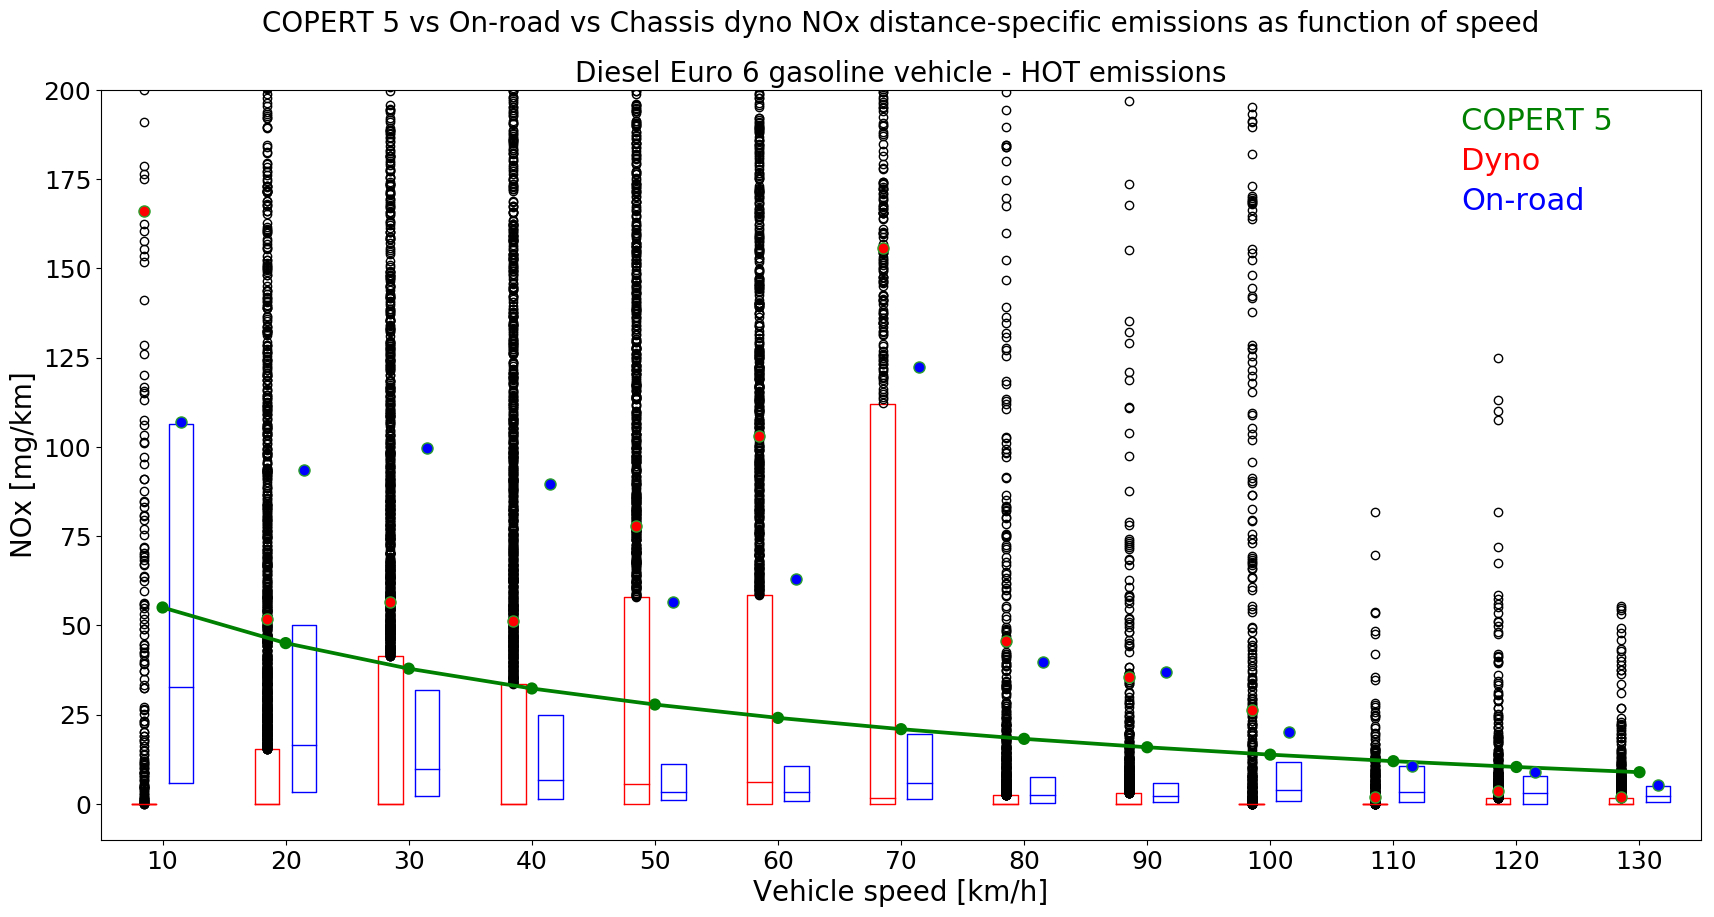

In [19]:
# fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
# #a4 is warm lab NOx
# bp = a4.boxplot(by='Speed range', return_type='dict',
#                 showmeans = True, grid = False, widths = 0.2, figsize=(20, 10),
#                 positions = np.arange(14)-0.15, showfliers = True, whis = [25,75], showcaps = False,
#                 meanprops=(dict(marker='o',markerfacecolor='red', markersize=8)),
#                 ax=ax0)
# [ [item.set_color('r') for item in bp[key]['boxes']] for key in bp.keys() ]
# [ [item.set_color('r') for item in bp[key]['medians']] for key in bp.keys() ]
# plt.ylabel('NOx [mg/km]', fontsize = 20)
# plt.xlabel('Vehicle speed [km/h]', fontsize = 20)
# #a3 is warm on-road NOx
# bp2 = a3.boxplot(by='Speed range', return_type='dict', showmeans = True, grid = False,
#                  widths = 0.2, figsize=(20, 10),
#                  positions = np.arange(14)+0.15, showfliers = False, whis = [25,75], showcaps = False,
#                  meanprops=(dict(marker='o',markerfacecolor='blue', markersize=8)),
#                  ax=ax0)
# [ [item.set_color('blue') for item in bp2[key]['boxes']] for key in bp2.keys() ]
# [ [item.set_color('blue') for item in bp2[key]['medians']] for key in bp2.keys() ]
# plt.ylabel('NOx [mg/km]', fontsize = 20)
# plt.xlabel('Vehicle speed [km/h]', fontsize = 20)
# plt.xticks(fontsize = 18)
# plt.yticks(fontsize = 18)
# plt.ylim(-10,200)
# plt.suptitle('COPERT 5 vs On-road vs Chassis dyno NOx distance-specific emissions as function of speed', fontsize = 20)
# import seaborn as sns
# if segment == 'N1-II':
#     sns.pointplot(x= COPERT_x, y= COPERT_NOxH_DLCV_y, color ='green')
#     plt.title('Diesel Euro 6 light commercial vehicle - HOT emissions', fontsize = 20)
# elif fuel_type == 'Gasoline':
#     sns.pointplot(x= COPERT_x, y= COPERT_NOxH_G_y, color ='green')
#     plt.title('Diesel Euro 6 gasoline vehicle - HOT emissions', fontsize = 20)
# elif fuel_type == 'Diesel':
#     sns.pointplot(x= COPERT_x, y= COPERT_NOxH_D_y, color ='green')
#     plt.title('Diesel Euro 6 diesel mini vehicle - HOT emissions', fontsize = 20)
# plt.figtext(0.78, 0.86, 'COPERT 5', fontsize = 22, color = 'green')
# plt.figtext(0.78, 0.82, 'Dyno', fontsize = 22, color = 'red')
# plt.figtext(0.78, 0.78, 'On-road', fontsize = 22, color = 'blue')
# plt.show()
# mpl.rcdefaults()